# 210719 Set Thresholds

In [1]:
using Mmap

In [2]:
using JSON
using DataFrames
using FilePathsBase
using FilePathsBase: /
using CSV
using Arrow
using HDF5
using ProgressMeter
using PlotlyJS

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-3001803325919674850\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-3937638201721597193\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-3001803325919674850\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [3]:
using Midas.Pairwise: npairs, iterpairs
using TriMatrices

## Setup

In [4]:
ENV["COLUMNS"] = 400
ENV["LINES"] = 100

100

In [5]:
DATESTR = "210719"
NBNAME = "$DATESTR-set-thresholds"

"210719-set-thresholds"

In [6]:
infiles = Dict(
    :distances => p"../../data/intermediate/200727-find-overlaps/genome-pw-distances.raw-float32",
    :db => p"data-intermediate/210718-compile-edits/",
    :data => p"data-intermediate/210718-calculate-additional-data/",
);

In [7]:
intermediate_out = p"data-intermediate" / NBNAME
isdir(intermediate_out) || mkdir(intermediate_out)

true

## Load data

### Taxonomy

In [8]:
taxa = DataFrame(Arrow.Table(string(infiles[:data] / "taxa.arrow")));

In [9]:
genome_assignments = Vector{Int}(open(JSON.parse, infiles[:db] / "genome-assignments.json"))
ngenomes = length(genome_assignments)

50752

In [10]:
tid_to_tidx = Dict(id => i for (i, id) in enumerate(taxa[!, :id]))

taxon_index(tid::Integer) = tid_to_tidx[tid]
taxon_index(tids::AbstractVector{<:Integer}) = taxon_index.(tids)

lookup_tid(tid, cols=:) = taxa[taxon_index(tid), cols]

lookup_tid (generic function with 2 methods)

### Distances

In [11]:
pw_data = Mmap.mmap(open(infiles[:distances]), Vector{Float32}, (npairs(ngenomes),));

pw_dists = TriMatrix(TriSymmetric{false}(), ngenomes, pw_data);

## Calculate thresholds

In [12]:
@assert !any(row.min_inter_dist <= row.manual_threshold for row in eachrow(taxa) if !isnan(row.manual_threshold))

In [13]:
taxa[!, :base_threshold] = [isnan(row.manual_threshold) ? row.diameter : row.manual_threshold for row in eachrow(taxa)];

In [14]:
MARGIN = 0.05

0.05

In [15]:
taxa[!, :final_threshold] = min.((1 - MARGIN) .* taxa.min_inter_dist, taxa.base_threshold);

In [16]:
taxa[!, :coverage] = @showprogress [
    count(<=(row.final_threshold), view(pw_dists, row.genomes, row.genomes)) / row.ngenomes ^ 2
    for row in eachrow(taxa)
];

Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| Time: 0:00:04


## Check results

In [17]:
SUMMARY_COLS = [:id, :ncbi_id, :name, :rank, :is_leaf, :ngenomes, :manual_threshold, :diameter, :min_inter_dist, :base_threshold, :final_threshold, :coverage];

In [18]:
# Margin reduces final threshold below manula threshold
taxa[
    @.(!isnan(taxa.manual_threshold) & (taxa.final_threshold < taxa.manual_threshold)),
    SUMMARY_COLS,
]

,id,ncbi_id,name,rank,is_leaf,ngenomes,manual_threshold,diameter,min_inter_dist,base_threshold,final_threshold,coverage
,Int64,Int64?,String,String?,Bool,Int64,Float64,Float32,Float32,Abstrac…,Float64,Float64
1,1547,29484,Yersinia frederiksenii,species,1,22,0.9,0.95911,0.921271,0.9,0.875207,0.442149
2,1909,missing,Bacillus cereus subgroup 2,missing,1,58,0.55,0.625607,0.568251,0.55,0.539839,0.771106
3,1932,missing,Escherichia coli subgroup 2,missing,1,2204,0.35,0.552925,0.364887,0.35,0.346643,0.241631


In [19]:
# Review taxa without thresholds
taxa[taxa.manual_threshold .== 0, SUMMARY_COLS]

,id,ncbi_id,name,rank,is_leaf,ngenomes,manual_threshold,diameter,min_inter_dist,base_threshold,final_threshold,coverage
,Int64,Int64?,String,String?,Bool,Int64,Float64,Float32,Float32,Abstrac…,Float64,Float64
1,161,620,Shigella,missing,0,680,0.0,0.581807,0.364887,0.0,0.0,0.00147059
2,1542,29461,Brucella suis,species,0,35,0.0,0.0677028,0.0220164,0.0,0.0,0.0285714
3,555,303,Pseudomonas putida,species,0,28,0.0,0.886751,0.833454,0.0,0.0,0.0357143
4,557,317,Pseudomonas syringae,species,0,110,0.0,0.914961,0.295101,0.0,0.0,0.00909091
5,1530,29438,Pseudomonas savastanoi,species,0,24,0.0,0.489886,0.297822,0.0,0.0,0.0416667
6,1762,47877,Pseudomonas amygdali,species,0,27,0.0,0.522444,0.295101,0.0,0.0,0.037037
7,620,550,Enterobacter cloacae,species,0,63,0.0,0.66532,0.28939,0.0,0.0,0.015873
8,1280,158836,Enterobacter hormaechei,species,0,159,0.0,0.607138,0.28939,0.0,0.0,0.00628931
9,644,621,Shigella boydii,species,0,13,0.0,0.296933,0.204837,0.0,0.0,0.0769231


In [20]:
# Taxa with least coverage
sort!(taxa[taxa.manual_threshold .!= 0, SUMMARY_COLS], :coverage)[1:25, :]

,id,ncbi_id,name,rank,is_leaf,ngenomes,manual_threshold,diameter,min_inter_dist,base_threshold,final_threshold,coverage
,Int64,Int64?,String,String?,Bool,Int64,Float64,Float32,Float32,Abstrac…,Float64,Float64
1,219,838,Prevotella,genus,0,91,NaN,0.998605,0.98806,0.998605,0.938657,0.0416616
2,443,1883,Streptomyces,genus,0,143,NaN,0.982099,0.861725,0.982099,0.818638,0.0808352
3,386,1578,Lactobacillus,genus,0,162,NaN,0.999557,0.959602,0.999557,0.911622,0.102271
4,296,1866885,Mycolicibacterium,genus,0,38,NaN,0.979046,0.963591,0.979046,0.915412,0.106648
5,10,2093,Mycoplasma,genus,0,161,NaN,1.0,0.98396,1.0,0.934762,0.135527
6,268,2767893,Lentilactobacillus,genus,0,17,NaN,0.990538,0.985879,0.990538,0.936585,0.148789
7,413,1716,Corynebacterium,genus,0,152,NaN,0.997962,0.976636,0.997962,0.927804,0.149671
8,262,2767887,Ligilactobacillus,genus,0,50,NaN,0.997708,0.98544,0.997708,0.936168,0.1536
9,462,53246,Pseudoalteromonas,genus,0,19,NaN,0.994676,0.994433,0.994676,0.944712,0.157895


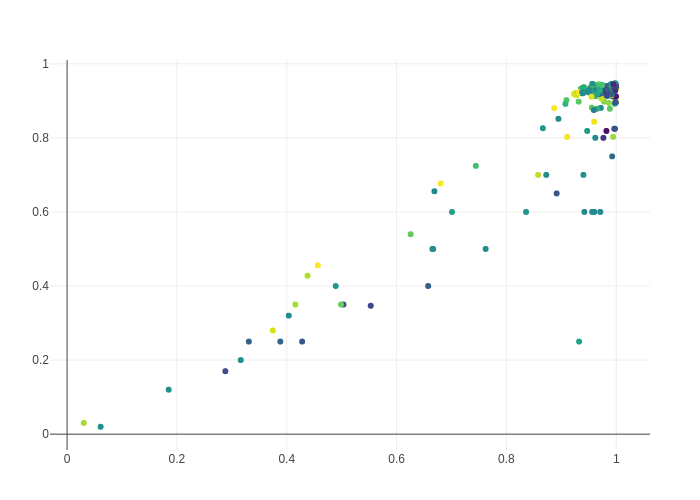

In [21]:
let
    rows = @. (taxa.coverage != 1) & (taxa.manual_threshold != 0)
    
    trace = scatter(
        x=taxa[rows, :diameter],
        y=taxa[rows, :final_threshold],
        text=taxa[rows, :plot_label],
        marker=attr(
            color=taxa[rows, :coverage],
            colorscale=:Viridis,
        ),
        mode=:markers,
        hovertemplate="(%{x:.3f}, %{y:.3f}, %{marker.color:.1%})<br>%{text}"
    )
    
    layout = Layout(
        hovermode=:closest,
    )
    
    plot(trace, layout)
end

## Write output

In [22]:
CSV.write(string(intermediate_out / "thresholds.csv"), taxa[!, [:id, :base_threshold, :final_threshold, :coverage]])

"data-intermediate/210719-set-thresholds/thresholds.csv"